# Train RoadMapper model 

This notebook trains a model to take in six images from the car's point of view, and output a bird's eye view map of the road.

It currently uses a modified version of [HRNet](https://github.com/HRNet/HRNet-Semantic-Segmentation) (Wang et. al. 2020).

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

from hrnet import get_seg_model

#!pip install yacs
from yacs.config import CfgNode as CN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [4]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/bs3743/DL-TopDownRoad/data'
annotation_csv = '/scratch/bs3743/DL-TopDownRoad/data/annotation.csv'

### Read in the labeled training data, and split into a training and validation set

In [5]:
# The scenes from 106 - 133 are labeled
labeled_scene_index = np.arange(106, 134)

In [6]:
# Split 75/25 into training and validation
random.shuffle(labeled_scene_index)
labeled_scene_index_train = labeled_scene_index[0:21]
labeled_scene_index_val = labeled_scene_index[21:28]
print("Train scenes: {} \nVal scenes: {}".format(len(labeled_scene_index_train), len(labeled_scene_index_val)))

Train scenes: 21 
Val scenes: 7


In [7]:
transform = torchvision.transforms.ToTensor()

In [8]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_train,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=5, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [9]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_val,
                                  transform=transform,
                                  extra_info=False
                                 )
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [10]:
sample, target, road_image = iter(trainloader).next()
print(torch.stack(sample).shape)
#print(torch.stack(sample)[:, 1, :, :].shape)

torch.Size([5, 6, 3, 256, 306])


### Train the model

In [11]:
# Create model config
# Note: I need to clean this up and move the whole config to a seperate file with the rest of it 

_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True
_C.RANK = 0

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'seg_hrnet'
_C.MODEL.PRETRAINED = ''
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.LOSS = CN()
_C.LOSS.USE_OHEM = False
_C.LOSS.OHEMTHRES = 0.9
_C.LOSS.OHEMKEEP = 100000
_C.LOSS.CLASS_BALANCE = True

# DATASET related params
_C.DATASET = CN()
_C.DATASET.ROOT = ''
_C.DATASET.NUM_CLASSES = 1
_C.DATASET.EXTRA_TRAIN_SET = ''

# training
_C.TRAIN = CN()

_C.TRAIN.IMAGE_SIZE = [1024, 512]  # width * height
_C.TRAIN.BASE_SIZE = 2048
_C.TRAIN.DOWNSAMPLERATE = 1
_C.TRAIN.FLIP = True
_C.TRAIN.MULTI_SCALE = True
_C.TRAIN.SCALE_FACTOR = 16

_C.TRAIN.LR_FACTOR = 0.1
_C.TRAIN.LR_STEP = [90, 110]
_C.TRAIN.LR = 0.0001
_C.TRAIN.EXTRA_LR = 0.001

_C.TRAIN.OPTIMIZER = 'sgd'
_C.TRAIN.MOMENTUM = 0.9
_C.TRAIN.WD = 0.0001
_C.TRAIN.NESTEROV = False
_C.TRAIN.IGNORE_LABEL = -1

_C.TRAIN.BEGIN_EPOCH = 0
_C.TRAIN.END_EPOCH = 484
_C.TRAIN.EXTRA_EPOCH = 0

_C.TRAIN.RESUME = False

_C.TRAIN.BATCH_SIZE_PER_GPU = 32
_C.TRAIN.SHUFFLE = True
# only using some training samples
_C.TRAIN.NUM_SAMPLES = 0

# testing
_C.TEST = CN()

_C.TEST.IMAGE_SIZE = [2048, 1024]  # width * height
_C.TEST.BASE_SIZE = 2048

_C.TEST.BATCH_SIZE_PER_GPU = 32
# only testing some samples
_C.TEST.NUM_SAMPLES = 0

_C.TEST.MODEL_FILE = ''
_C.TEST.FLIP_TEST = False
_C.TEST.MULTI_SCALE = False
_C.TEST.SCALE_LIST = [1]

# debug
_C.DEBUG = CN()
_C.DEBUG.DEBUG = False
_C.DEBUG.SAVE_BATCH_IMAGES_GT = False
_C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
_C.DEBUG.SAVE_HEATMAPS_GT = False
_C.DEBUG.SAVE_HEATMAPS_PRED = False
_C.defrost()
_C.merge_from_file("hrnet_config.yaml")
_C.freeze()
    
config = _C

In [12]:
# Initialize model
model = get_seg_model(config)
model = model.to(device)

In [13]:
# Intialize loss
loss = nn.BCELoss()

In [14]:
# Intialize optimizer
optimizer = torch.optim.SGD([{'params':
                                  filter(lambda p: p.requires_grad,
                                         model.parameters()),
                                  'lr': config.TRAIN.LR}],
                                lr=config.TRAIN.LR,
                                momentum=config.TRAIN.MOMENTUM,
                                weight_decay=config.TRAIN.WD,
                                nesterov=config.TRAIN.NESTEROV,
                                )

In [15]:
# Create training function
def train(train_loader, model, optimizer, criterion, epoch):
    
    model.train()

    for batch_idx, (sample, target, road_image) in enumerate(train_loader):
        
        # Send to device
        sample, road_image = torch.stack(sample).to(device),  torch.stack(road_image).float().to(device) # takes only one image for now
        batch_size = sample.shape[0]
        sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])
        # for now, take only one image
        #sample = sample[:, 1, :, :]
        
        # Run through model
        optimizer.zero_grad()
        output = model(sample)
        
        # Calculate loss and take step
        loss = criterion(output, road_image)
        loss.backward()
        optimizer.step()
        
        # Log progress
        if batch_idx % 100 == 0:
            print('\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
    return


In [16]:
# Create an evaluation function
def evaluate(val_loader, model, criterion):
    model.eval()
    losses = []
    tp, fp, fn = 0, 0, 0
    for batch_idx, (sample, target, road_image) in enumerate(val_loader):
        # send to device
        sample, road_image = torch.stack(sample).to(device), torch.stack(road_image).float().to(device) # takes only one image for now
        batch_size = sample.shape[0]
        sample = sample.view(batch_size, -1, 256, 306) # torch.Size([3, 18, 256, 306])
        
        with torch.no_grad():
            output = model(sample)
            
        # Calculate loss
        loss = criterion(output, road_image)
        losses.append(loss)
        
        # Calculate TP, FP, FN for threat score
        output_class = (output > 0.5).float()
        tp = tp + torch.sum(torch.mul(output_class, road_image))
        fp = fp + torch.sum(torch.mul(torch.eq(output_class, 1), torch.eq(road_image, 0)))
        fn = fn + torch.sum(torch.mul(torch.eq(output_class, 0), torch.eq(road_image, 1)))
    
    # Calculate metrics
    loss = sum(losses)/len(losses)
    threat_score = tp/(tp+fp+fn)
    
    return loss, threat_score


In [17]:
# Train

min_val_loss = np.inf

for epoch in range(10):
    
    # Train for one epoch
    train(trainloader, model, optimizer, loss, epoch)
    
    # Evaluate at the end of the epoch
    print("Evaluating after Epoch {}:".format(epoch))
    val_loss, val_threat_score = evaluate(valloader, model, loss)
    print("Val loss is {:.6f}, threat score is {:.6f}".format(val_loss, val_threat_score))
    
    # If this is the best model so far, save it
    if val_loss < min_val_loss:
        torch.save({
            'epoch': epoch,
            'config': config,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            }, 'models/best_road_mapper_lr10e-5.pt')
    


/home/bs3743/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/bs3743/.conda/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


	Train Epoch: 0 [0/2646 (0%)]	Loss: 0.691431
	Train Epoch: 0 [500/2646 (19%)]	Loss: 0.416411
	Train Epoch: 0 [1000/2646 (38%)]	Loss: 0.345700
	Train Epoch: 0 [1500/2646 (57%)]	Loss: 0.382323
	Train Epoch: 0 [2000/2646 (75%)]	Loss: 0.323156
	Train Epoch: 0 [2500/2646 (94%)]	Loss: 0.336568
Evaluating after Epoch 0:
Val loss is 0.500869, threat score is 0.597588
	Train Epoch: 1 [0/2646 (0%)]	Loss: 0.350144
	Train Epoch: 1 [500/2646 (19%)]	Loss: 0.390007
	Train Epoch: 1 [1000/2646 (38%)]	Loss: 0.390539
	Train Epoch: 1 [1500/2646 (57%)]	Loss: 0.297388
	Train Epoch: 1 [2000/2646 (75%)]	Loss: 0.502754
	Train Epoch: 1 [2500/2646 (94%)]	Loss: 0.241669
Evaluating after Epoch 1:
Val loss is 0.456529, threat score is 0.595045
	Train Epoch: 2 [0/2646 (0%)]	Loss: 0.311796
	Train Epoch: 2 [500/2646 (19%)]	Loss: 0.430734
	Train Epoch: 2 [1000/2646 (38%)]	Loss: 0.609381
	Train Epoch: 2 [1500/2646 (57%)]	Loss: 0.287492
	Train Epoch: 2 [2000/2646 (75%)]	Loss: 0.235843
	Train Epoch: 2 [2500/2646 (94%)]	Lo

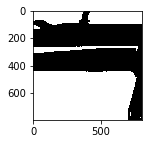

In [38]:
matplotlib.rcParams['figure.figsize'] = [2, 2]

# Visualize results
sample, target, road_image = iter(valloader).next()
image = sample[0].view(-1, 256, 306)
#plt.imshow(image.numpy().transpose(1, 2, 0))
#plt.axis('off')
# True road image
fig, ax = plt.subplots()
ax.imshow(road_image[0], cmap='binary')

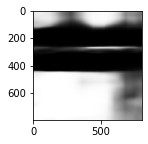

In [39]:
# Predicted road image
output = model(image.unsqueeze(0).to(device))
fig, ax = plt.subplots()
ax.imshow(output.cpu().detach().numpy().squeeze(0), cmap='binary')